In [1]:
%load_ext autoreload
%autoreload 2

from model.feedforward import FeedForwardLayer
import torch
from model.attention import MultiHeadAttention
from model.decoder import Decoder
import numpy as np

In [2]:
from tokenizer.tokenizer  import Tokenizer
tknz = Tokenizer(None, None, None, None)
tknz.load("/Users/bayesian_monster/llama/llama")

In [3]:
from dataset.dataset import LLaMaDataset, collate_fn
from torch.utils.data import DataLoader
dataset = LLaMaDataset("/Users/bayesian_monster/llama/train_files")
train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=10)


In [13]:
NUM_EPOCH = 1000
EMB_DIM=128
NUM_HEAD=2
EXP_FACTOR=2
NUM_LAYERS=2
DROPOUT=0.1
DEVICE = "cpu"
model = Decoder(emb_dim=EMB_DIM,
                num_head=NUM_HEAD,
                exp_factor=EXP_FACTOR, 
                num_layers=NUM_LAYERS, 
                dropout=DROPOUT, 
                use_rope=False)
optimzer = torch.optim.AdamW(model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.2, ignore_index=3)

In [14]:
batch = next(iter(train_dataloader))["sentence"]
out = model(batch)

In [15]:
out.shape, batch.shape

(torch.Size([10, 255, 32000]), torch.Size([10, 255]))

In [16]:
from tqdm.notebook import tqdm
def train_epoch(model, optimzer, criterion):
    model.train()
    LOSS = []
    for epoch in tqdm(range(NUM_EPOCH), desc="train"):
        losses = 0
        for batch in train_dataloader:
            batch['sentence'] = batch['sentence']
            logits = model(batch["sentence"])
            optimzer.zero_grad()
            tgt_out = batch['sentence']
            loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1).long())
            loss.backward()
            optimzer.step()
            losses += loss.item()

        losses = losses / len(list(train_dataloader))

        LOSS += [losses]
    return LOSS


In [17]:
LOSS = train_epoch(model, optimzer, criterion)

train:   0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
import matplotlib.pyplot as plt

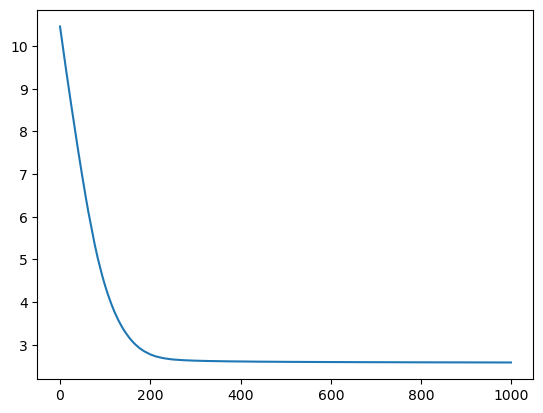

In [20]:
plt.plot(LOSS)